In [6]:
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import numpy as np

# Pipeline Goal
1. Download Dataset from the website for our specified date/source period
2. Put into panda dataset for easy manipulation
3. Plot Data (ensure it works)
4. Data Manipulation
    a. Set Threshold value
    b. Get rid of 

## Putting Dataset into Pandas

In [4]:
columns = ["Year", "Day", "Hour", "DSCOV Bz_gse, nT", "WIND Bz_gse, nT" , "ACE Bz_gse, nT"]

file_path = "data/readings.lst"
df = pd.read_csv(file_path, sep = "\s+", header=None, names= columns)
df.head()

,Year,Day,Hour,"DSCOV Bz_gse, nT","WIND Bz_gse, nT","ACE Bz_gse, nT"
0,2016,156,0,999.9,-0.1,0.4
1,2016,156,1,1.1,1.1,1.1
2,2016,156,2,0.4,0.3,0.6
3,2016,156,3,0.3,0.1,-0.1
4,2016,156,4,-1.0,0.0,-0.6


In [52]:
# merge Year Day hour into one column
df["Date-Time"] = pd.to_datetime(df[["Year", "Day", "Hour"]].astype(str).agg('-'.join, axis=1), format="%Y-%j-%H")
df.set_index('Date-Time', inplace=True)
df.head()

,Year,Day,Hour,"DSCOV Bz_gse, nT","WIND Bz_gse, nT","ACE Bz_gse, nT"
Date-Time,,,,,,
2016-06-04 00:00:00,2016,156,0,999.9,-0.1,0.4
2016-06-04 01:00:00,2016,156,1,1.1,1.1,1.1
2016-06-04 02:00:00,2016,156,2,0.4,0.3,0.6
2016-06-04 03:00:00,2016,156,3,0.3,0.1,-0.1
2016-06-04 04:00:00,2016,156,4,-1.0,0.0,-0.6


In [55]:
# Remove all 999.99, replace with NaN
df.loc[df["DSCOV Bz_gse, nT"] == 999.9, "DSCOV Bz_gse, nT"] = None
df.loc[df["WIND Bz_gse, nT"] == 999.9, "WIND Bz_gse, nT"] = None
df.loc[df["ACE Bz_gse, nT"] == 999.9, "ACE Bz_gse, nT"] = None

df.head()

,Year,Day,Hour,"DSCOV Bz_gse, nT","WIND Bz_gse, nT","ACE Bz_gse, nT"
Date-Time,,,,,,
2016-06-04 00:00:00,2016,156,0,NaN,-0.1,0.4
2016-06-04 01:00:00,2016,156,1,1.1,1.1,1.1
2016-06-04 02:00:00,2016,156,2,0.4,0.3,0.6
2016-06-04 03:00:00,2016,156,3,0.3,0.1,-0.1
2016-06-04 04:00:00,2016,156,4,-1.0,0.0,-0.6


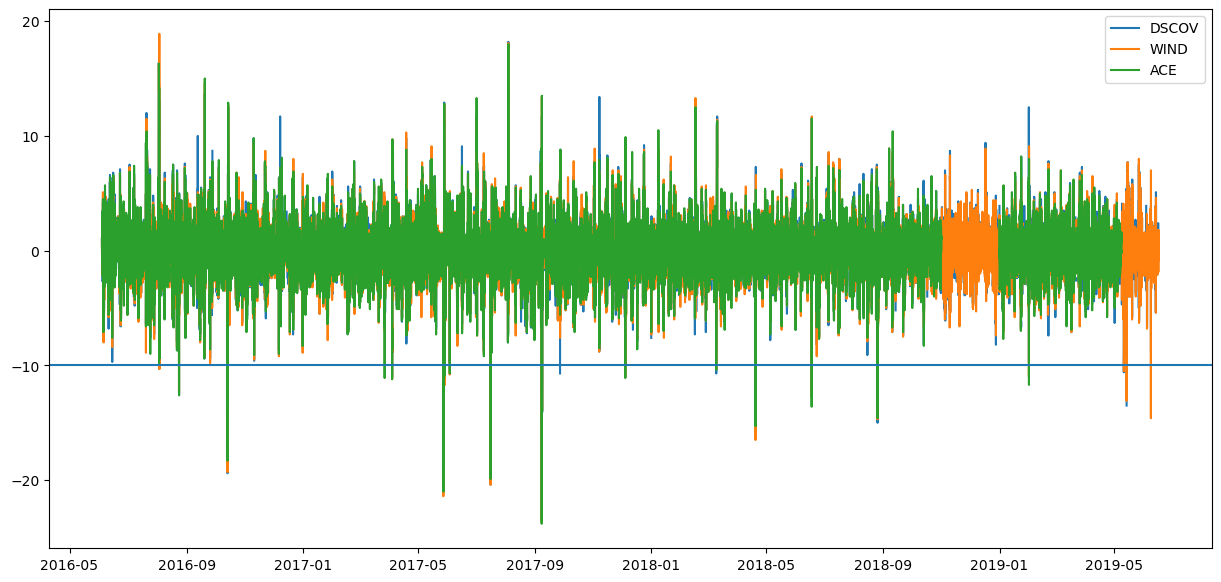

In [67]:
plt.figure(figsize=(15, 7))
plt.plot(df["DSCOV Bz_gse, nT"], label = "DSCOV")
plt.plot(df["WIND Bz_gse, nT"], label = "WIND")
plt.plot(df["ACE Bz_gse, nT"], label = "ACE")

plt.axhline(y=-10)
plt.legend()
plt.show()

# Visualization

- Look at plotting average, median, range
- How many are NaN, etc

# Thresholding
Thresholding, and oogabooga, average time based on threshold

In [59]:
df2 = df.copy()

,Year,Day,Hour,"DSCOV Bz_gse, nT","WIND Bz_gse, nT","ACE Bz_gse, nT"
Date-Time,,,,,,
2016-06-04 00:00:00,2016,156,0,NaN,-0.1,0.4
2016-06-04 01:00:00,2016,156,1,1.1,1.1,1.1
2016-06-04 02:00:00,2016,156,2,0.4,0.3,0.6
2016-06-04 03:00:00,2016,156,3,0.3,0.1,-0.1
2016-06-04 04:00:00,2016,156,4,-1.0,0.0,-0.6


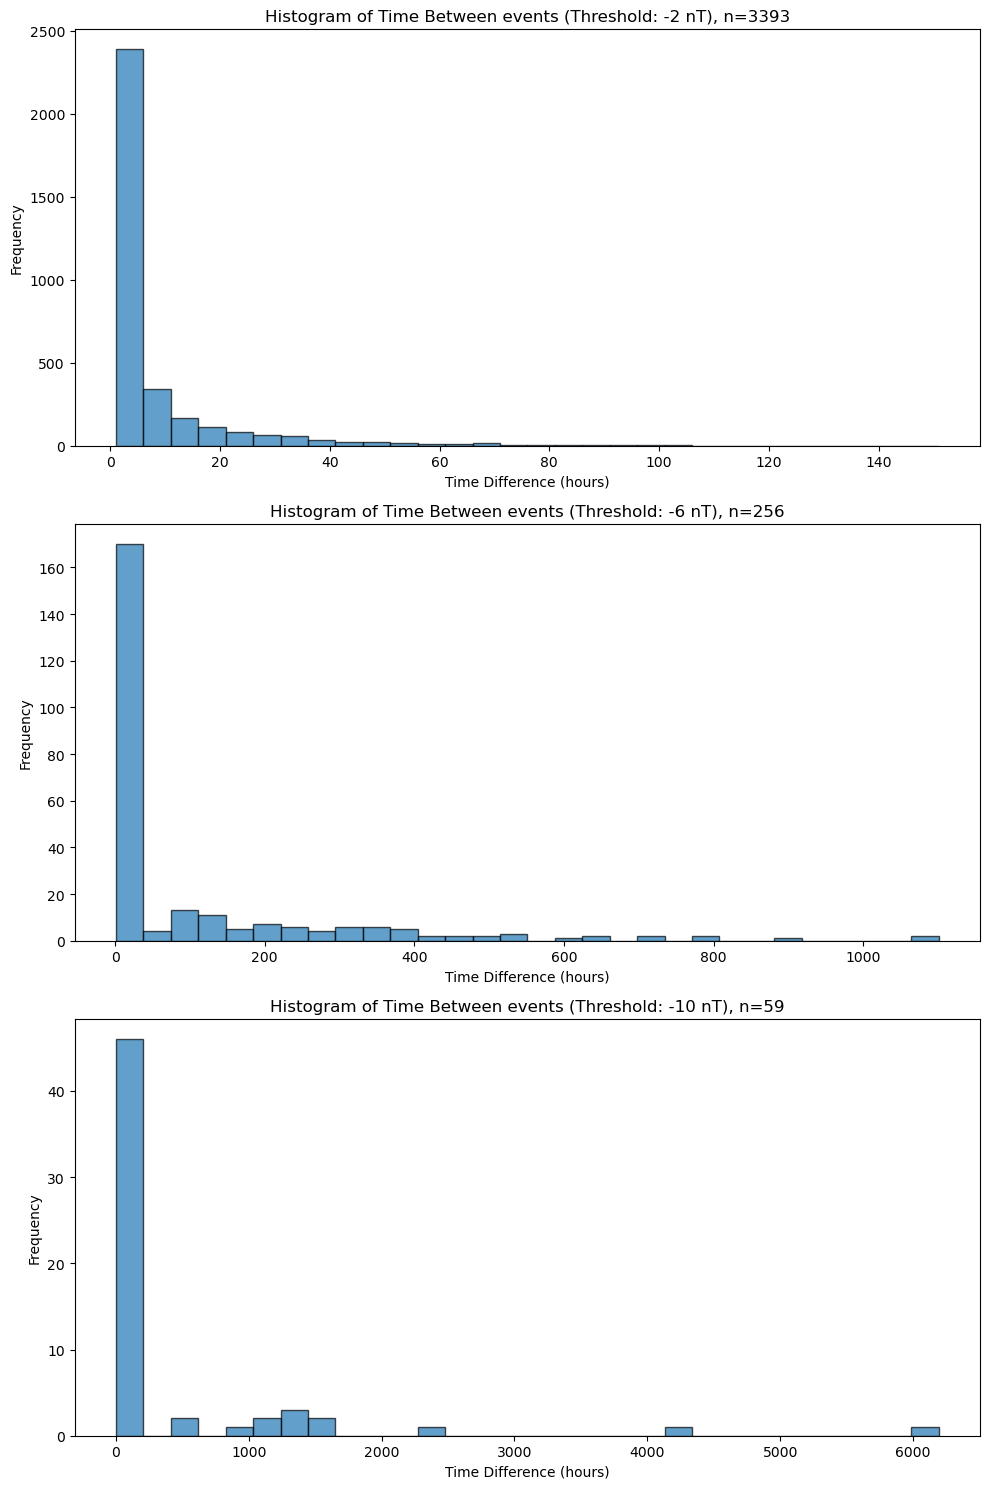

In [107]:
thresholds = [-2, -6, -10] #in nT

fig, axs = plt.subplots(len(thresholds), figsize=(10, 5*len(thresholds)))
for i, threshold in enumerate(thresholds):
    DSCOV_IMF_times = df2.index[ df2["DSCOV Bz_gse, nT"] <= threshold]
    DSCOV_IMF_time_diffs = DSCOV_IMF_times[1:] - DSCOV_IMF_times[:-1]
    # print("Number of IMF below {threshold} nT threshold: ", len(DSCOV_IMF_time_diffs))

    DSCOV_IMF_time_diffs_hrs = DSCOV_IMF_time_diffs.total_seconds() / 3600  
    axs[i].hist(DSCOV_IMF_time_diffs_hrs, bins=30, edgecolor='k', alpha=0.7)
    axs[i].set_title(f'Histogram of Time Between events (Threshold: {threshold} nT), n={len(DSCOV_IMF_time_diffs)}')
    axs[i].set_xlabel('Time Difference (hours)')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
DSCOV_IMF_times = df2.index[ df2["DSCOV Bz_gse, nT"] < -6]
plt.plot()

# SPRECTRAL ANALYSIS --> FOURIER TRANSFORM?

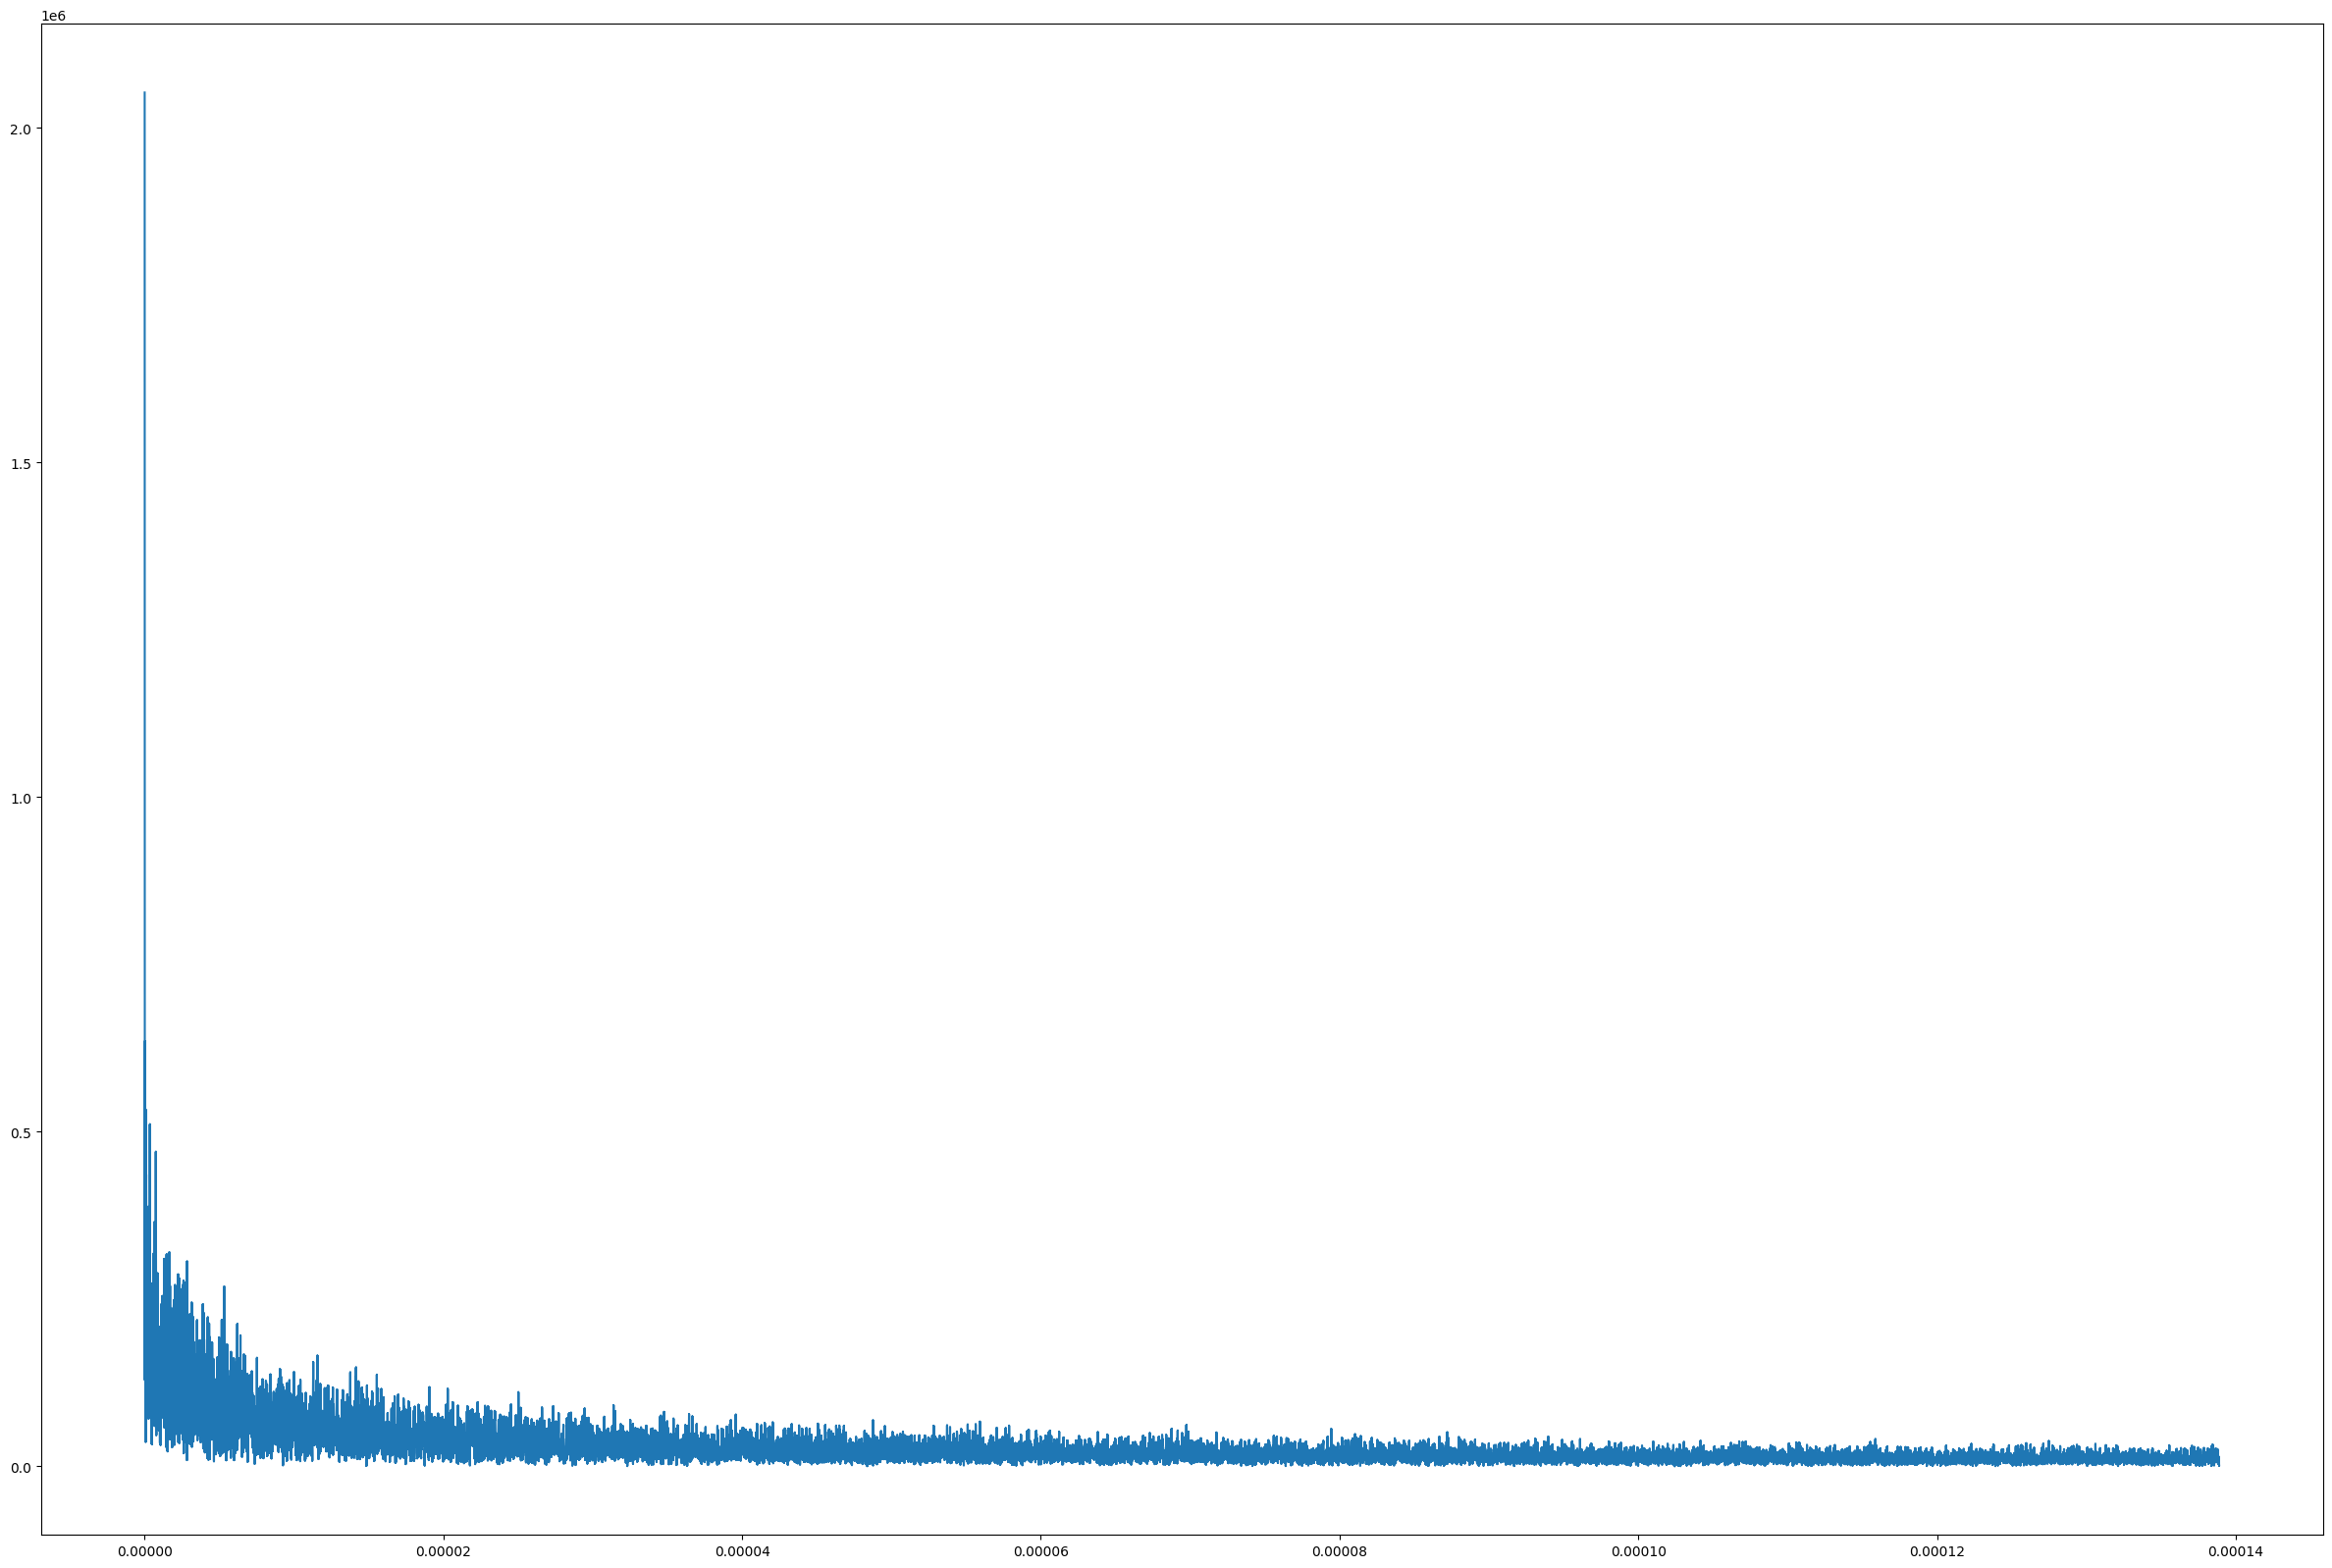

In [7]:
# Fourier transform of DSCOV <= -10nT
# I KN SOMETHING IS WRONG BUT IDK WHAT IT IS, CUZ SUPPOSE THE FREQ CORRESPONDING TO PEAK MAGNITUDE IS 1? OR NO? IDK
from scipy.fft import fft, fftfreq

df_noNAN = df.copy().dropna()
sample_rate = 1/3600
y = df_noNAN['DSCOV Bz_gse, nT']
duration = len(y)*3600
N = int(sample_rate*duration)
yf = fft(np.array(y))
xf = fftfreq(N, 1 / sample_rate)

f=plt.figure()
f.set_figwidth(30)
f.set_figheight(20)
plt.plot(np.abs(xf), np.abs(yf))
#plt.rcParams['figure.figsize']=[100,10]
plt.show()

# Research


In [ ]:
#threshold: -10nT --> https://www.spaceweatherlive.com/en/help/the-interplanetary-magnetic-field-imf.html
# when DSCOVR B > 25nT: sm WIND measurements are significantly smaller. 
# ACE & Wind are universally consistent, we suggest using ACE or Wind measurement of the
# magnetic field when the apparent field strength from DSCOVR is above 25nT

# lists of dates of CME (coronal mass ejection) --> we can determine the threshold using that
